In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pandas.tseries.offsets import WeekOfMonth
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency


In [2]:
#Carga de datos
ruta = 'Datos.xlsx'
datos_ventas = pd.read_excel(ruta, sheet_name=0)
datos_calendario = pd.read_excel(ruta, sheet_name=1)
datos_promos = pd.read_excel(ruta, sheet_name=2)
datos_stock = pd.read_excel(ruta, sheet_name=3)

# stock

In [3]:
datos_ventas.head()

,producto,idSecuencia,udsVenta
0,1,20221105,40
1,1,20221106,0
2,1,20221107,12
3,1,20221108,28
4,1,20221109,14


In [4]:
datos_ventas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654408 entries, 0 to 654407
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   producto     654408 non-null  int64
 1   idSecuencia  654408 non-null  int64
 2   udsVenta     654408 non-null  int64
dtypes: int64(3)
memory usage: 15.0 MB


No hay nulos en el dataset de ventas.

In [5]:
datos_ventas.describe()

,producto,idSecuencia,udsVenta
count,654408.000000,6.544080e+05,654408.000000
mean,502.115213,2.023412e+07,1.438500
std,291.228968,6.061684e+03,2.698971
min,1.000000,2.022110e+07,0.000000
25%,247.000000,2.023051e+07,0.000000
50%,506.500000,2.023111e+07,0.000000
75%,754.000000,2.024051e+07,2.000000
max,1000.000000,2.024110e+07,181.000000


Como id_secuencia es una fecha, pero no lo está tomando como tal, se convierte a datetime.

In [6]:
datos_ventas['idSecuencia'] = pd.to_datetime(datos_ventas['idSecuencia'], format = '%Y%m%d')

In [7]:
datos_ventas.describe()

,producto,idSecuencia,udsVenta
count,654408.000000,654408,654408.000000
mean,502.115213,2023-11-05 11:59:59.999999488,1.438500
min,1.000000,2022-11-05 00:00:00,0.000000
25%,247.000000,2023-05-06 18:00:00,0.000000
50%,506.500000,2023-11-05 12:00:00,0.000000
75%,754.000000,2024-05-06 06:00:00,2.000000
max,1000.000000,2024-11-05 00:00:00,181.000000
std,291.228968,NaN,2.698971


Con el resumen anterior podemos ver que el dataset de ventas cuenta con los siguientes datos:
- **producto**: identificador único de la pieza. Se cuenta con mil productos [1,1000]
- **idSecuencia**: fechas de venta. Se cuenta con datos desde el 05-11-2022 hasta el 05-11-2024.
- **udsVenta**: unidades vendidas. Desde 0 hasta 181 unidades.

En total el conjunto cuenta con 654408 registros. Además, como vemos cuando se ha ejecutado el comando info, no cuenta con valores nulos.

Revisamos si cuenta con duplicados.

In [8]:
datos_ventas.duplicated().sum()

np.int64(0)

Se van a revisar los outliers de udsVenta.

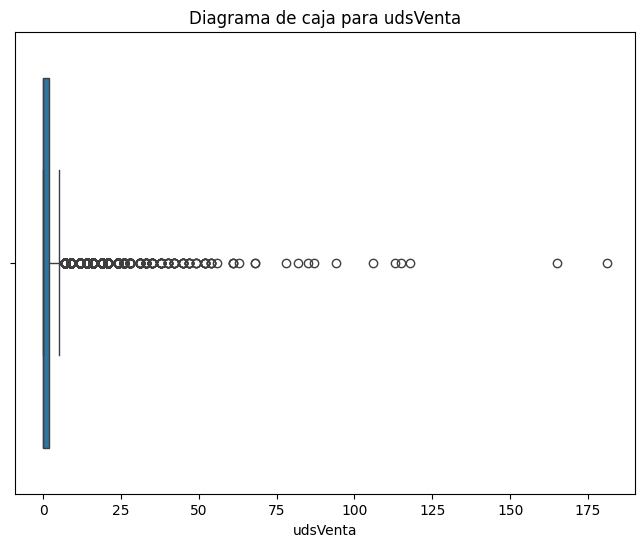

In [9]:
plt.figure(figsize=(8,6))
sns.boxplot(x=datos_ventas['udsVenta'])
plt.title('Diagrama de caja para udsVenta')
plt.xlabel('udsVenta')
plt.show()

A primera vista contamos con outliers. Después de la primera exploración completa de los datos, los analizaremos más a fondo.

# Calendario

In [10]:
datos_calendario.head()

,idSecuencia,bolOpen,bolHoliday
0,20250205,1,0
1,20250206,1,0
2,20231223,1,0
3,20231224,1,1
4,20240902,1,0


In [11]:
datos_calendario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 837 entries, 0 to 836
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   idSecuencia  837 non-null    int64
 1   bolOpen      837 non-null    int64
 2   bolHoliday   837 non-null    int64
dtypes: int64(3)
memory usage: 19.7 KB


Al igual que en el caso anterior, idSecuencia es de tipo int, y vamos a convertirlo a datetime puesto que se trata de una fecha.

In [12]:
datos_calendario['idSecuencia'] = pd.to_datetime(datos_calendario['idSecuencia'], format='%Y%m%d')

In [13]:
datos_calendario.describe()

,idSecuencia,bolOpen,bolHoliday
count,837,837.000000,837.000000
mean,2023-12-29 00:00:00,0.850657,0.166069
min,2022-11-06 00:00:00,0.000000,0.000000
25%,2023-06-03 00:00:00,1.000000,0.000000
50%,2023-12-29 00:00:00,1.000000,0.000000
75%,2024-07-25 00:00:00,1.000000,0.000000
max,2025-02-19 00:00:00,1.000000,1.000000
std,NaN,0.356639,0.372365


Se cuenta con los siguientes datos:
- **idSecuencia**: dimensión de fecha. Se cuenta con datos desde el 05-06-2022 hasta el 19-02-2025.
- **bolOpen**: indicador booleano. Si es 1, indica apertura del punto de venta, 0 si está cerrado.
- **bolHoliday**: indicador booleano. Si es 1 indica fecha festivo, 0 si no.

En total, el conjunto cuenta con 837 registros. Como de puede ver en la info, no cuenta con valores nulos.

Revisamos si cuenta con valores duplicados.

In [14]:
datos_calendario.duplicated().sum()

np.int64(0)

# Promociones

In [15]:
datos_promos.head()

,producto,idSecuenciaIni,idSecuenciaFin
0,469,20120927,20121121
1,554,20151009,20151117
2,972,20130112,20130311
3,117,20220811,20220907
4,399,20210506,20210606


In [16]:
datos_promos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24718 entries, 0 to 24717
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   producto        24718 non-null  int64
 1   idSecuenciaIni  24718 non-null  int64
 2   idSecuenciaFin  24718 non-null  int64
dtypes: int64(3)
memory usage: 579.5 KB


Vamos a convertir idSecuenciaIni y idSecuenciaFin a datetime.

In [17]:
datos_promos['idSecuenciaIni'] = pd.to_datetime(datos_promos['idSecuenciaIni'], format='%Y%m%d')
datos_promos['idSecuenciaFin'] = pd.to_datetime(datos_promos['idSecuenciaFin'], format='%Y%m%d')

In [18]:
datos_promos.describe()

,producto,idSecuenciaIni,idSecuenciaFin
count,24718.000000,24718,24718
mean,442.293551,2019-01-23 16:46:34.012460288,2019-02-25 09:34:35.410631936
min,1.000000,2011-01-04 00:00:00,2011-01-11 00:00:00
25%,174.000000,2016-09-01 00:00:00,2016-09-30 00:00:00
50%,427.000000,2019-05-16 00:00:00,2019-06-13 00:00:00
75%,685.000000,2021-10-21 00:00:00,2021-11-17 00:00:00
max,999.000000,2024-11-07 00:00:00,2024-12-04 00:00:00
std,299.079545,NaN,NaN


Contamos con los siguientes datos:
- **producto**: identificador único de producto. En este caso, vemos que van de 1 a 999.
- **idSecuenciaIni**: fecha de inicion de promoción. Desde el 04-01-2011 al 07-11-2024.
- **idSecuenciaFin**: fecha fin de la promoción. DEsde el 11-1-2011 al 04-12-2024.

En total, el conjunto cuenta con 24718 registros, y no contiene nulos. Vamos a ver si contiene duplicados.

In [19]:
datos_promos.duplicated().sum()

np.int64(0)

Vamos a ver cuantos productos únicos estuvieron en promoción.

In [20]:
datos_promos['producto'].nunique()

610

# Stock

In [21]:
datos_stock.head()

,producto,idSecuencia,udsStock
0,240,20240103,71
1,240,20240104,71
2,240,20240105,71
3,240,20240106,68
4,240,20240107,68


In [22]:
datos_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654408 entries, 0 to 654407
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   producto     654408 non-null  int64
 1   idSecuencia  654408 non-null  int64
 2   udsStock     654408 non-null  int64
dtypes: int64(3)
memory usage: 15.0 MB


Vamos a transformar idSecuencia a formato fecha.

In [23]:
datos_stock['idSecuencia'] = pd.to_datetime(datos_stock['idSecuencia'], format='%Y%m%d')

In [24]:
datos_stock.describe()

,producto,idSecuencia,udsStock
count,654408.000000,654408,654408.000000
mean,502.115213,2023-11-06 11:59:59.999999744,56.037996
min,1.000000,2022-11-06 00:00:00,0.000000
25%,247.000000,2023-05-07 18:00:00,33.000000
50%,506.500000,2023-11-06 12:00:00,49.000000
75%,754.000000,2024-05-07 06:00:00,71.000000
max,1000.000000,2024-11-06 00:00:00,947.000000
std,291.228968,NaN,43.176785


Se cuenta con los siguientes datos:
- **producto**: identificador único del producto. Se cuenta con mil productos: [1,1000]
- **idSecuencia**: fecha de stock. Se cuenta con datos desde 06-11-2022 hasta el 06-11-2024.
- **udsStock**: unidades en stock. Se cuenta con datos que van desde el 0 a 947.

En total, el conjunto cuenta con 654408 registros, y no hay ningún nulo.

Revisamos si hay duplicados.

In [25]:
datos_stock.duplicated().sum()

np.int64(0)

Vamos a revisar los outliers.

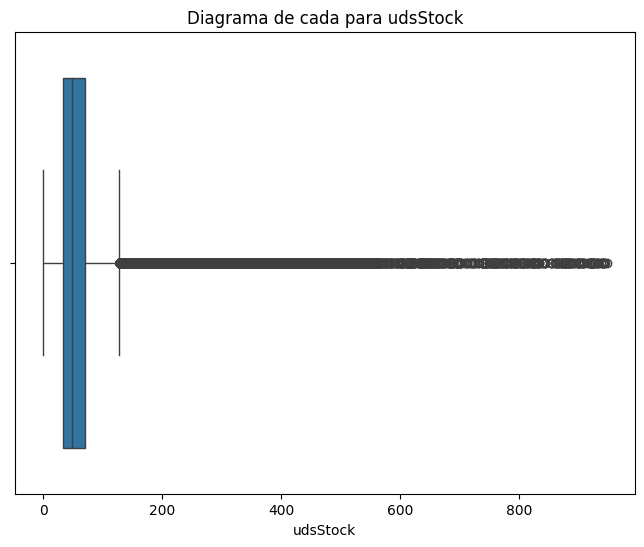

In [26]:
plt.figure(figsize=(8,6))
sns.boxplot(x=datos_stock['udsStock'])
plt.title('Diagrama de cada para udsStock')
plt.xlabel('udsStock')
plt.show()

Se observa que tenemos valores outliers, que seran evaluados más adelante.

# Conjunto de datos integrado

Una vez revisados los 4 datasets de manera individual, vamos a unirlos de manera que solo nos quede uno para realizar un análisis exhaustivo. 

Se van a unir los datos de ventas, stock y calendario en primer lugar.

In [27]:
datos_ventas_stock = pd.merge(datos_ventas, datos_stock, on =['idSecuencia', 'producto'], how = 'outer')
datos_ventas_stock_calendario = pd.merge(datos_ventas_stock, datos_calendario, on = ['idSecuencia'], how='left')

In [28]:
datos_ventas_stock_calendario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655302 entries, 0 to 655301
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   producto     655302 non-null  int64         
 1   idSecuencia  655302 non-null  datetime64[ns]
 2   udsVenta     654408 non-null  float64       
 3   udsStock     654408 non-null  float64       
 4   bolOpen      654408 non-null  float64       
 5   bolHoliday   654408 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 30.0 MB


Vamos a crear una variable isPromo para los días en los que el producto se encuentra en promoción.

In [29]:
# Merge por producto
df = datos_ventas_stock_calendario.merge(datos_promos, on='producto', how='left')

# Comprobamos si la secuencia está dentro del rango
df['isPromo'] = (
    (df['idSecuencia'] >= df['idSecuenciaIni']) &
    (df['idSecuencia'] <= df['idSecuenciaFin'])
).astype(int)

# Si te queda varias coincidencias por venta, te quedas con la máxima (1 si hay promo)
df = df.groupby(['producto', 'idSecuencia'], as_index=False).agg({'isPromo': 'max'})

# Lo unes de vuelta a tu dataset original
datos_ventas_stock_calendario = datos_ventas_stock_calendario.merge(df, on=['producto', 'idSecuencia'], how='left')

# Rellena nulos (productos sin promo)
datos_ventas_stock_calendario['isPromo'] = datos_ventas_stock_calendario['isPromo'].fillna(0).astype(int)


In [30]:
datos_ventas_stock_calendario.describe()

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,isPromo
count,655302.000000,655302,654408.000000,654408.000000,654408.000000,654408.000000,655302.000000
mean,502.115213,2023-11-06 00:00:00.000000256,1.438500,56.037996,0.833333,0.185792,0.130795
min,1.000000,2022-11-05 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,247.000000,2023-05-07 00:00:00,0.000000,33.000000,1.000000,0.000000,0.000000
50%,506.500000,2023-11-06 00:00:00,0.000000,49.000000,1.000000,0.000000,0.000000
75%,754.000000,2024-05-07 00:00:00,2.000000,71.000000,1.000000,0.000000,0.000000
max,1000.000000,2024-11-06 00:00:00,181.000000,947.000000,1.000000,1.000000,1.000000
std,291.228968,NaN,2.698971,43.176785,0.372678,0.388939,0.337176


Revisamos posibles nulos y duplicados por los cruces.

In [31]:
nan_count = datos_ventas_stock_calendario.isnull().sum()
duplicated_count = datos_ventas_stock_calendario.duplicated().sum()

print('Nulos:\n', nan_count)
print('Duplicados:', duplicated_count)


Nulos:
 producto         0
idSecuencia      0
udsVenta       894
udsStock       894
bolOpen        894
bolHoliday     894
isPromo          0
dtype: int64
Duplicados: 0


In [32]:
datos_ventas_stock_calendario[datos_ventas_stock_calendario['udsVenta'].isnull()]

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,isPromo
654408,1,2024-11-06,NaN,280.0,1.0,0.0,0
654409,2,2024-11-06,NaN,129.0,1.0,0.0,0
654410,3,2024-11-06,NaN,103.0,1.0,0.0,0
654411,4,2024-11-06,NaN,89.0,1.0,0.0,0
654412,5,2024-11-06,NaN,212.0,1.0,0.0,0
...,...,...,...,...,...,...,...
655297,996,2024-11-06,NaN,49.0,1.0,0.0,0
655298,997,2024-11-06,NaN,35.0,1.0,0.0,0
655299,998,2024-11-06,NaN,94.0,1.0,0.0,1
655300,999,2024-11-06,NaN,75.0,1.0,0.0,0


Hay días que tenemos stock pero no tenemos unidades de venta. Vamos a eliminar estos días del conjunto de datos puesto que pueden desvirtuar la tendencia de ventas. 

In [33]:
datos_ventas_stock_calendario = datos_ventas_stock_calendario.dropna(subset=['udsVenta'])

In [34]:
datos_ventas_stock_calendario.isnull().sum()

producto         0
idSecuencia      0
udsVenta         0
udsStock       894
bolOpen        894
bolHoliday     894
isPromo          0
dtype: int64

Vamos a observar los nulos en las unidades de stock.

In [35]:
datos_ventas_stock_calendario[datos_ventas_stock_calendario['udsStock'].isnull()].describe()

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,isPromo
count,894.000000,894,894.000000,0.0,0.0,0.0,894.000000
mean,502.115213,2022-11-04 23:59:59.999999744,2.730425,NaN,NaN,NaN,0.168904
min,1.000000,2022-11-05 00:00:00,0.000000,NaN,NaN,NaN,0.000000
25%,247.250000,2022-11-05 00:00:00,0.000000,NaN,NaN,NaN,0.000000
50%,506.500000,2022-11-05 00:00:00,2.000000,NaN,NaN,NaN,0.000000
75%,753.750000,2022-11-05 00:00:00,5.000000,NaN,NaN,NaN,0.000000
max,1000.000000,2022-11-05 00:00:00,40.000000,NaN,NaN,NaN,1.000000
std,291.391762,NaN,3.917405,NaN,NaN,NaN,0.374877


Como se puede ver, los nulos en las unidades de stock y que si tienen unidades de venta, se concentran en el día 05-11-2022. Esto pasa por que el dataset de ventas tiene datos desde este día mientras el dataset de stock cuenta con datos desde el día siguiente, 06-11-2022. Por lo tanto, vamos a descartar estos datos.

In [36]:
datos_ventas_stock_calendario = datos_ventas_stock_calendario.dropna(subset=['udsStock'])

In [37]:
datos_ventas_stock_calendario.isnull().sum()

producto       0
idSecuencia    0
udsVenta       0
udsStock       0
bolOpen        0
bolHoliday     0
isPromo        0
dtype: int64

Observamos que nuestro dataset ya no contiene nulos.

Convertimos a int las columnas definidas como float puesto que son números enteros.

In [38]:
columnas_convertir = ['udsVenta', 'udsStock', 'bolOpen', 'bolHoliday']
datos_ventas_stock_calendario[columnas_convertir] = datos_ventas_stock_calendario[columnas_convertir].astype(int)
datos_ventas_stock_calendario.info()

<class 'pandas.core.frame.DataFrame'>
Index: 653514 entries, 894 to 654407
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   producto     653514 non-null  int64         
 1   idSecuencia  653514 non-null  datetime64[ns]
 2   udsVenta     653514 non-null  int64         
 3   udsStock     653514 non-null  int64         
 4   bolOpen      653514 non-null  int64         
 5   bolHoliday   653514 non-null  int64         
 6   isPromo      653514 non-null  int64         
dtypes: datetime64[ns](1), int64(6)
memory usage: 39.9 MB


Vamos a crear unas columnas que nos ayuden a graficar los datos para la exploración inicial. Se crean las columnas año, mes, dia, dia de la semana, semana del mes y semana del año.

In [39]:
# Creamos las columnas año, mes, día
datos_ventas_stock_calendario['año'] = datos_ventas_stock_calendario['idSecuencia'].dt.year.astype(int)
datos_ventas_stock_calendario['mes'] = datos_ventas_stock_calendario['idSecuencia'].dt.month.astype(int)
datos_ventas_stock_calendario['dia'] = datos_ventas_stock_calendario['idSecuencia'].dt.day.astype(int)

# Creamos las columnas día de la semana, semana del año y semana del mes
datos_ventas_stock_calendario['dia_semana'] = datos_ventas_stock_calendario['idSecuencia'].dt.day_of_week.astype(int)
datos_ventas_stock_calendario['semana'] = datos_ventas_stock_calendario['idSecuencia'].dt.isocalendar().week.astype(int)

def semana_mes_series(fechas: pd.Series) -> pd.Series:
    # Primer día del mes
    primer_dia_mes = fechas - pd.to_timedelta(fechas.dt.day - 1, unit='D')
    
    # Convertimos a int para evitar overflow
    dia_mes = fechas.dt.day.astype('int')
    weekday_mes = primer_dia_mes.dt.weekday.astype('int')

    return ((dia_mes + weekday_mes - 1) // 7 + 1).astype(int)

datos_ventas_stock_calendario['semana_mes'] = semana_mes_series(
    datos_ventas_stock_calendario['idSecuencia']
)



In [40]:
datos_ventas_stock_calendario.describe()

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,isPromo,año,mes,dia,dia_semana,semana,semana_mes
count,653514.000000,653514,653514.000000,653514.000000,653514.000000,653514.000000,653514.000000,653514.000000,653514.000000,653514.000000,653514.000000,653514.000000,653514.000000
mean,502.115213,2023-11-06 00:00:00,1.436733,56.028282,0.833105,0.186047,0.130778,2023.347469,6.519836,15.738714,2.997264,26.574555,3.084815
min,1.000000,2022-11-06 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,2022.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,247.000000,2023-05-07 00:00:00,0.000000,33.000000,1.000000,0.000000,0.000000,2023.000000,4.000000,8.000000,1.000000,14.000000,2.000000
50%,506.500000,2023-11-06 00:00:00,0.000000,49.000000,1.000000,0.000000,0.000000,2023.000000,7.000000,16.000000,3.000000,27.000000,3.000000
75%,754.000000,2024-05-07 00:00:00,2.000000,71.000000,1.000000,0.000000,0.000000,2024.000000,10.000000,23.000000,5.000000,40.000000,4.000000
max,1000.000000,2024-11-05 00:00:00,181.000000,947.000000,1.000000,1.000000,1.000000,2024.000000,12.000000,31.000000,6.000000,52.000000,6.000000
std,291.228969,NaN,2.696507,43.147862,0.372882,0.389144,0.337157,0.616401,3.449554,8.803928,2.003417,15.022507,1.314313


In [41]:
datos_ventas_stock_calendario[datos_ventas_stock_calendario['semana_mes'] == 6]['idSecuencia'].unique().tolist()

[Timestamp('2023-01-30 00:00:00'),
 Timestamp('2023-01-31 00:00:00'),
 Timestamp('2023-07-31 00:00:00'),
 Timestamp('2023-10-30 00:00:00'),
 Timestamp('2023-10-31 00:00:00'),
 Timestamp('2024-09-30 00:00:00')]

Estos casos que la semana del mes es 6, son muy pocos, y solo cuentan con un día o dos de ese mes en la semana. Para que no desvirtuen los datos, vamos a considerar que los días que son de semana 6 pertenen a semana 5.

In [42]:
datos_ventas_stock_calendario['semana_mes'] = datos_ventas_stock_calendario['semana_mes'].clip(upper=5)
datos_ventas_stock_calendario.describe()

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,isPromo,año,mes,dia,dia_semana,semana,semana_mes
count,653514.000000,653514,653514.000000,653514.000000,653514.000000,653514.000000,653514.000000,653514.000000,653514.000000,653514.000000,653514.000000,653514.000000,653514.000000
mean,502.115213,2023-11-06 00:00:00,1.436733,56.028282,0.833105,0.186047,0.130778,2023.347469,6.519836,15.738714,2.997264,26.574555,3.076607
min,1.000000,2022-11-06 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,2022.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,247.000000,2023-05-07 00:00:00,0.000000,33.000000,1.000000,0.000000,0.000000,2023.000000,4.000000,8.000000,1.000000,14.000000,2.000000
50%,506.500000,2023-11-06 00:00:00,0.000000,49.000000,1.000000,0.000000,0.000000,2023.000000,7.000000,16.000000,3.000000,27.000000,3.000000
75%,754.000000,2024-05-07 00:00:00,2.000000,71.000000,1.000000,0.000000,0.000000,2024.000000,10.000000,23.000000,5.000000,40.000000,4.000000
max,1000.000000,2024-11-05 00:00:00,181.000000,947.000000,1.000000,1.000000,1.000000,2024.000000,12.000000,31.000000,6.000000,52.000000,5.000000
std,291.228969,NaN,2.696507,43.147862,0.372882,0.389144,0.337157,0.616401,3.449554,8.803928,2.003417,15.022507,1.299117


# Análisis conjunto

Una vez tenemos el dataset completo, vamos a realizar un análisis de las ventas y stock. Para ello, vamos a graficar los datos.



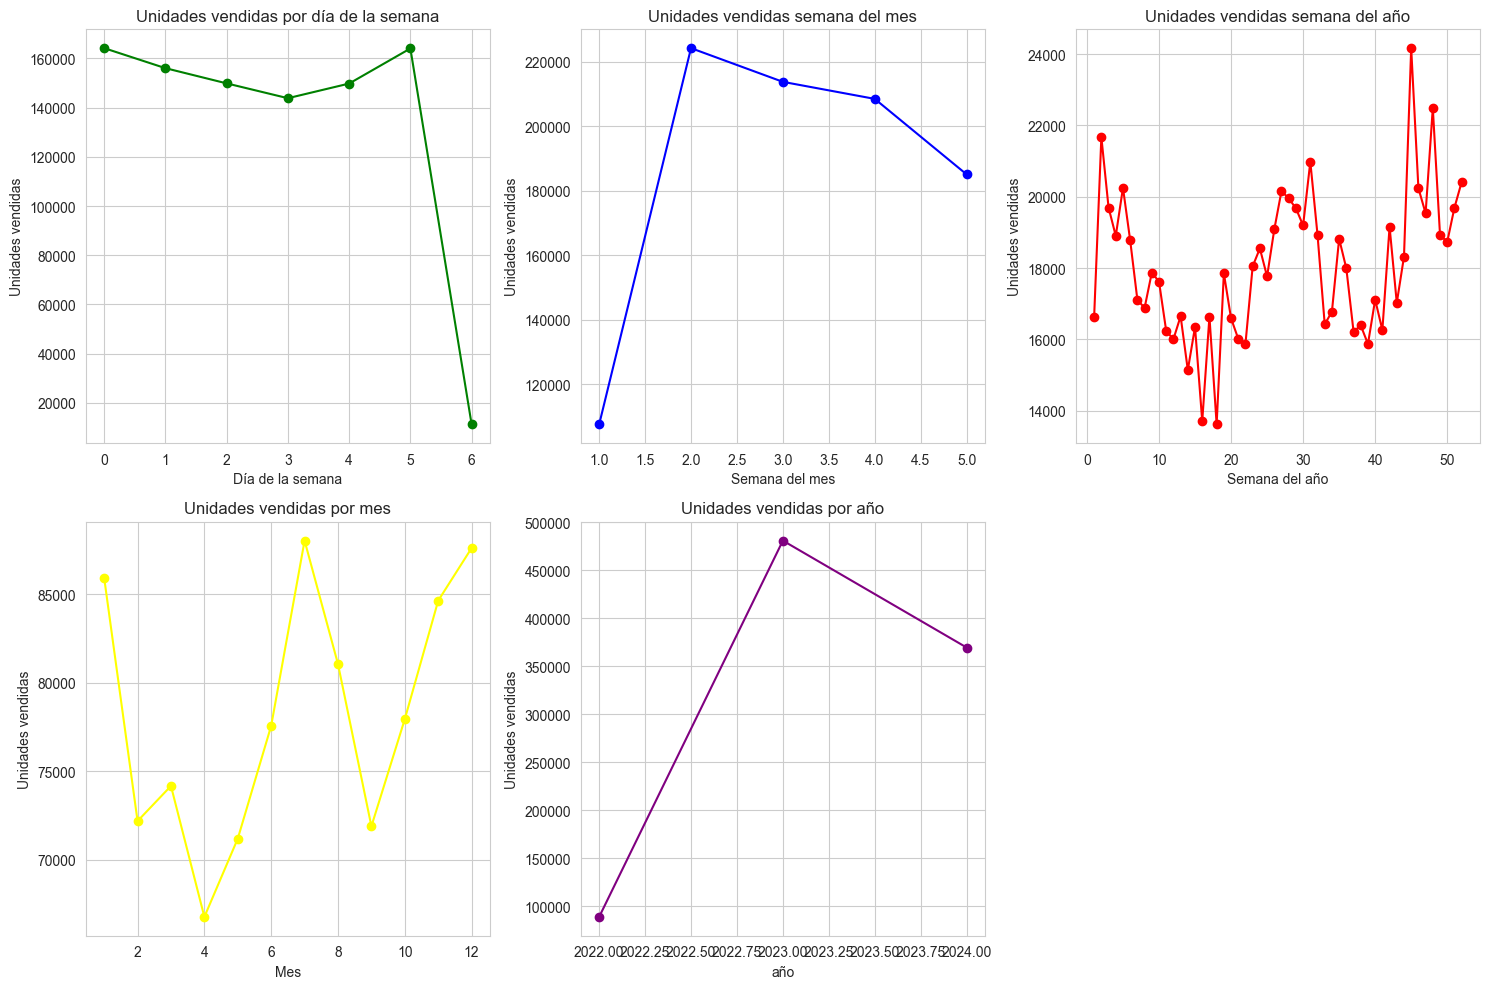

In [43]:
# Calculamos las uds vendidas por día de la semana, semana del mes, semana del año, mes y año

ventas_dia_semana = datos_ventas_stock_calendario.groupby(datos_ventas_stock_calendario['dia_semana'])['udsVenta'].sum()
ventas_senana_mes = datos_ventas_stock_calendario.groupby(datos_ventas_stock_calendario['semana_mes'])['udsVenta'].sum()
ventas_semana_año = datos_ventas_stock_calendario.groupby(datos_ventas_stock_calendario['semana'])['udsVenta'].sum()
ventas_mes = datos_ventas_stock_calendario.groupby(datos_ventas_stock_calendario['mes'])['udsVenta'].sum()
ventas_año = datos_ventas_stock_calendario.groupby(datos_ventas_stock_calendario['año'])['udsVenta'].sum()

# Configurar las gráficas
sns.set_style('whitegrid')
plt.figure(figsize=(15,10))

# Gráfica ventas por día de la semana
plt.subplot(2,3,1)
plt.plot(ventas_dia_semana.index, ventas_dia_semana.values, marker='o', color='green')
plt.title('Unidades vendidas por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Unidades vendidas')

# Gráfica de ventas por semana del mes
plt.subplot(2,3,2)
plt.plot(ventas_senana_mes.index, ventas_senana_mes.values, marker='o', color='blue')
plt.title('Unidades vendidas semana del mes')
plt.xlabel('Semana del mes')
plt.ylabel('Unidades vendidas')

# Gráfica de ventas por semana del año
plt.subplot(2,3,3)
plt.plot(ventas_semana_año.index, ventas_semana_año.values, marker='o', color='red')
plt.title('Unidades vendidas semana del año')
plt.xlabel('Semana del año')
plt.ylabel('Unidades vendidas')

# Gráfica de ventas por mes
plt.subplot(2,3,4)
plt.plot(ventas_mes.index, ventas_mes.values, marker='o', color='yellow')
plt.title('Unidades vendidas por mes')
plt.xlabel('Mes')
plt.ylabel('Unidades vendidas')

# Gráfica de ventas por año
plt.subplot(2,3,5)
plt.plot(ventas_año.index, ventas_año.values, marker='o', color='purple')
plt.title('Unidades vendidas por año')
plt.xlabel('año')
plt.ylabel('Unidades vendidas')

plt.tight_layout()
plt.show()

De las gráficas anteriores podemos extraer las siguientes conclusiones:

- Las ventas son mucho mayores entre lunes y sabado, con un pico fuerte en lunes y sabado, y muestran un desplome drástico los domingos.
- Alcanzan su máximo en la segunda semana del mes, y después van descendiendo. Sugiere un patrón mensual.
- Existe estacionalidad anual, la demanda es muy alta en semanas finales, y existen caídas en semanas 15-20. No son estables en el año, hay variabilidad moderada-alta.
- Destacan enero, junio, noviembre y diciembre como meses de mayores ventas. Abril es el més más debil.


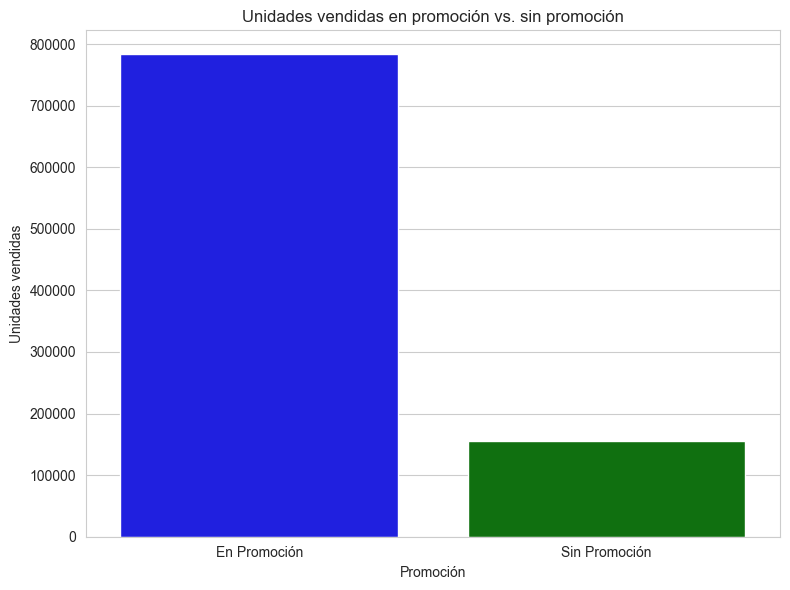

In [44]:
# Se calcula cuantas unidades se vendieron estando en promoción
ventas_por_promo = datos_ventas_stock_calendario.groupby('isPromo')['udsVenta'].sum().reset_index()

# Configuramos la gráfica

sns.set_style('whitegrid')
plt.figure(figsize=(8,6))

# Gráfica de las unidades vendidas en promo
sns.barplot(data=ventas_por_promo, x='isPromo', y='udsVenta', hue='isPromo', palette=['blue', 'green'], legend=False)
plt.title('Unidades vendidas en promoción vs. sin promoción')
plt.xlabel('Promoción')
plt.ylabel('Unidades vendidas')
plt.xticks([0,1], ['En Promoción', 'Sin Promoción'])

plt.tight_layout()
plt.show()

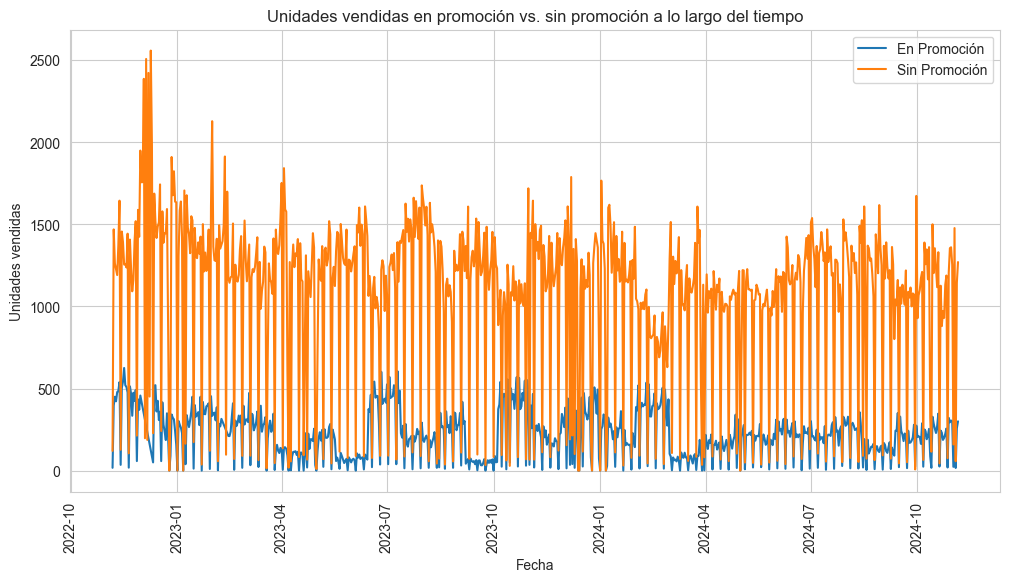

In [45]:
# Graficamos las unidades vendidas en promoción y sin promoción a lo largo del tiempo
ventas_en_promo = datos_ventas_stock_calendario[datos_ventas_stock_calendario['isPromo'] == 1]
ventas_sin_promo = datos_ventas_stock_calendario[datos_ventas_stock_calendario['isPromo']== 0]

# Calculamos las uds vendidas para cada categoría
ventas_en_promo_sum = ventas_en_promo.groupby('idSecuencia')['udsVenta'].sum().reset_index()
ventas_sin_promo_sum = ventas_sin_promo.groupby('idSecuencia')['udsVenta'].sum().reset_index()

# Graficamos
sns.set_style('whitegrid')
plt.figure(figsize=(12,6))
sns.lineplot(data=ventas_en_promo_sum, x='idSecuencia', y='udsVenta', label = 'En Promoción')
sns.lineplot(data=ventas_sin_promo_sum, x='idSecuencia', y='udsVenta', label = 'Sin Promoción')

plt.title('Unidades vendidas en promoción vs. sin promoción a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Unidades vendidas')

plt.xticks(rotation=90)
plt.legend()
plt.show()

De las dos gráficas anteriores podemos sacar las siguientes conclusiones:

- La promoción incrementa las ventas, pero NO domina en cantidad de días. La primera gráfica muestra que más del 80% de las ventas totales se realizaron en días con promoción, lo que sugiere un impacto enorme. Sin embargo, la gráfica temporal aclara el contexto: Los días sin promoción son MUCHOS más que los días en promoción, por eso su volumen acumulado es tan grande.

- En días sin promoción, las ventas muestran un ciclo semanal muy fuerte. La línea naranja tiene un patrón serrado muy marcado:
    - Picos repetitivos → sábados / días fuertes del negocio
    - Valles profundos → domingos / días de cierre

- Las ventas en promoción son más suaves, menos volátiles y con picos concretos. La línea azul no aparece todos los dias. Tiene menos variabilidad que la línea sin promoción. Los picos coinciden con campañas promocionales específicas, no con el ciclo semanal. Esto indica que la promoción introduce un impulso extra pero no elimina la estacionalidad base del producto y que la dinámica de demanda en promoción depende más del calendario promocional que del ciclo semanal.

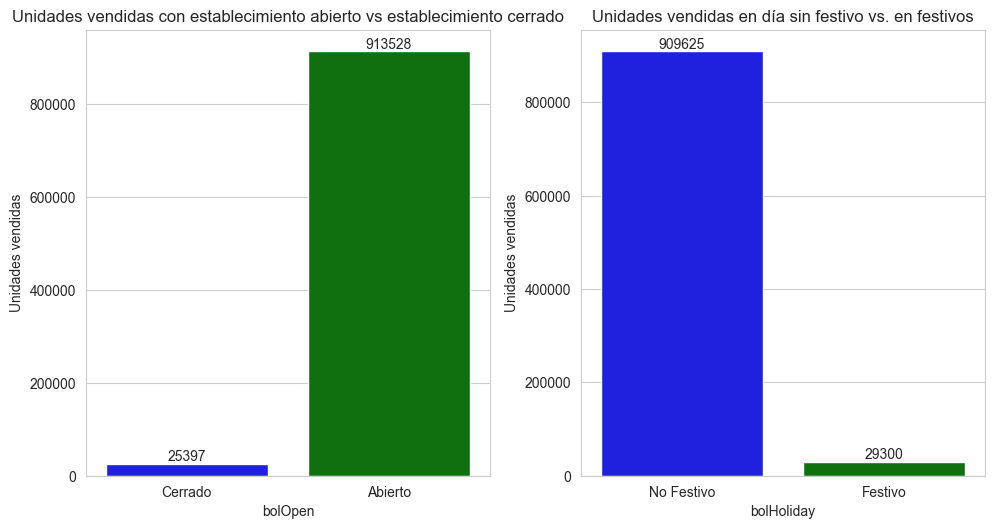

In [46]:
# Analizamos las ventas cuando el establecimiento está abierto o cerrado y en festivos
ventas_por_bolOpen = datos_ventas_stock_calendario.groupby('bolOpen')['udsVenta'].sum().reset_index()
ventas_por_bolHoliday = datos_ventas_stock_calendario.groupby('bolHoliday')['udsVenta'].sum().reset_index()

sns.set_style('whitegrid')
plt.figure(figsize=(15,10))

# Gráfica de las unidades vendidas por bolOpen
plt.subplot(2,3,1)
ax = sns.barplot(data=ventas_por_bolOpen, x='bolOpen', y='udsVenta', hue='bolOpen', palette=['blue', 'green'], legend=False)
plt.title('Unidades vendidas con establecimiento abierto vs establecimiento cerrado')
plt.xlabel('bolOpen')
plt.ylabel('Unidades vendidas')
plt.xticks([0,1], ['Cerrado', 'Abierto'])

# Añadir etiquetas encima de cada barra
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f')  # sin decimale

# Gráfica de las unidades vendidas por bolHoliday
plt.subplot(2,3,2)
ax1 = sns.barplot(data=ventas_por_bolHoliday, x='bolHoliday', y='udsVenta', hue='bolHoliday', palette=['blue', 'green'], legend=False)
plt.title('Unidades vendidas en día sin festivo vs. en festivos')
plt.xlabel('bolHoliday')
plt.ylabel('Unidades vendidas')
plt.xticks([0,1], ['No Festivo', 'Festivo'])

# Añadir etiquetas encima de cada barra
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.0f')  # sin decimale

plt.tight_layout()
plt.show()

De la gráfica anterior extraemos las siguientes conclusiones:

- El establecimiento abierto es el factor más determinante para que existan ventas. Con establecimiento cerrado, se vendieron 25.397 unidades (apenas un 2,7% del total).
Por lo tanto, el establecimiento genera prácticamente toda su demanda cuando está abierto. Las ventas en días cerrados probablemente corresponden a operaciones residuales, ventas de stock histórico, errores de registro o ventas online (si existiera canal).

- Los días festivos reducen drásticamente las ventas, se vende solo un 3% de lo que se vende un día normal. Los días festivos afectan severamente al flujo de clientes o a los horarios de apertura. La variable bolHoliday sí tiene impacto y ayudará a mejorar la precisión del modelo, especialmente en combinaciones como:
    - festivo + establecimiento cerrado
    - festivo + día de baja demanda.

Vamos a comprobar si existe algún tipo de estacionalidad, tendencia o heterocedasticidad

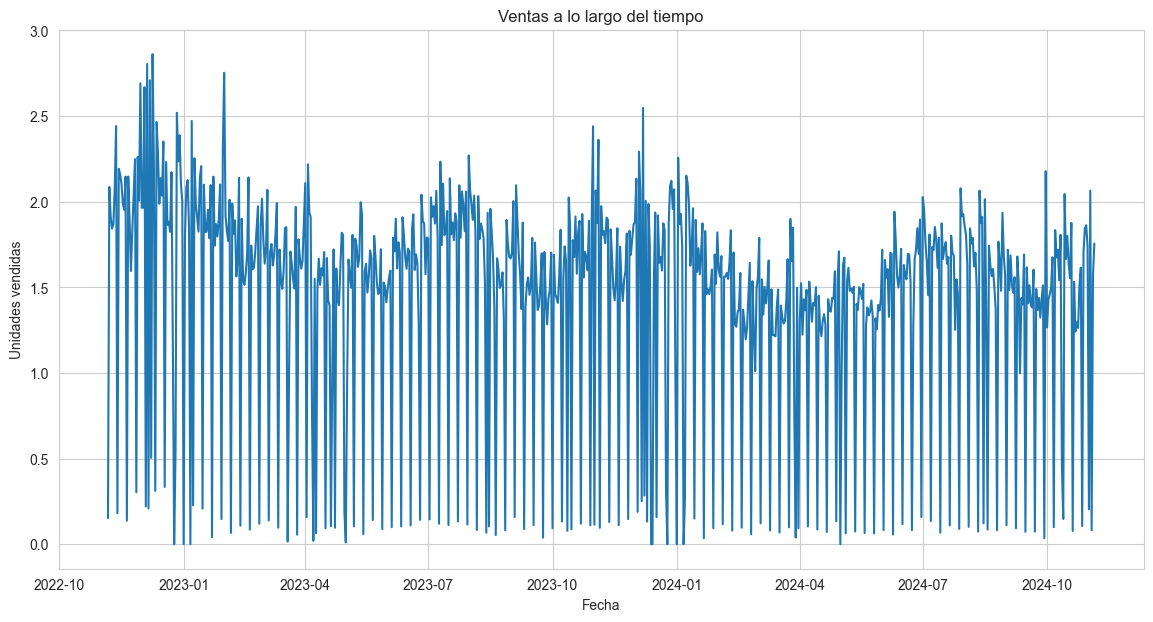

In [47]:
plt.figure(figsize=(14,7))

sns.lineplot(data=datos_ventas_stock_calendario, x='idSecuencia', y='udsVenta', errorbar=None)
plt.title('Ventas a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Unidades vendidas')
plt.show()

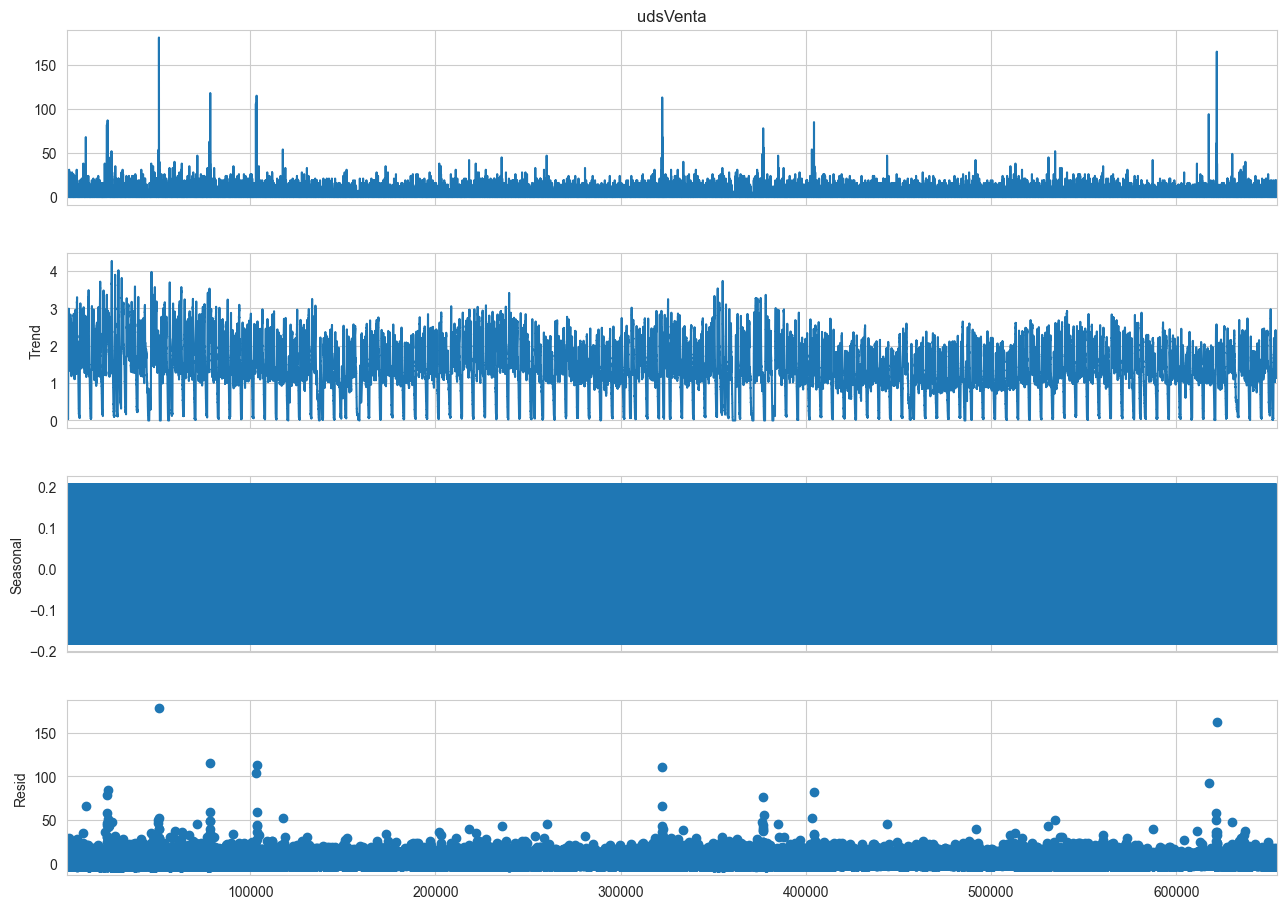

In [64]:
# Descomposición de la serie temporal
descomposicion = sm.tsa.seasonal_decompose(datos_ventas_stock_calendario['udsVenta'], model='additive', period=365)
fig = descomposicion.plot()
fig.set_size_inches(14,10)
plt.show()

La gráfica anterior no nos sirve para mucho. Esto ocurre por que la descomposición solo funciona bien cuando hay un valor por periodo. En este caso, tenemos múltiples ventas al días, lo que provoca que no se pueda extraer un patrón regular. Por eso el seasonal aparece como un bloque plano, no detecta estacionalidad. Por ello, vamos a analizarlo con las ventas agrupadas por día.

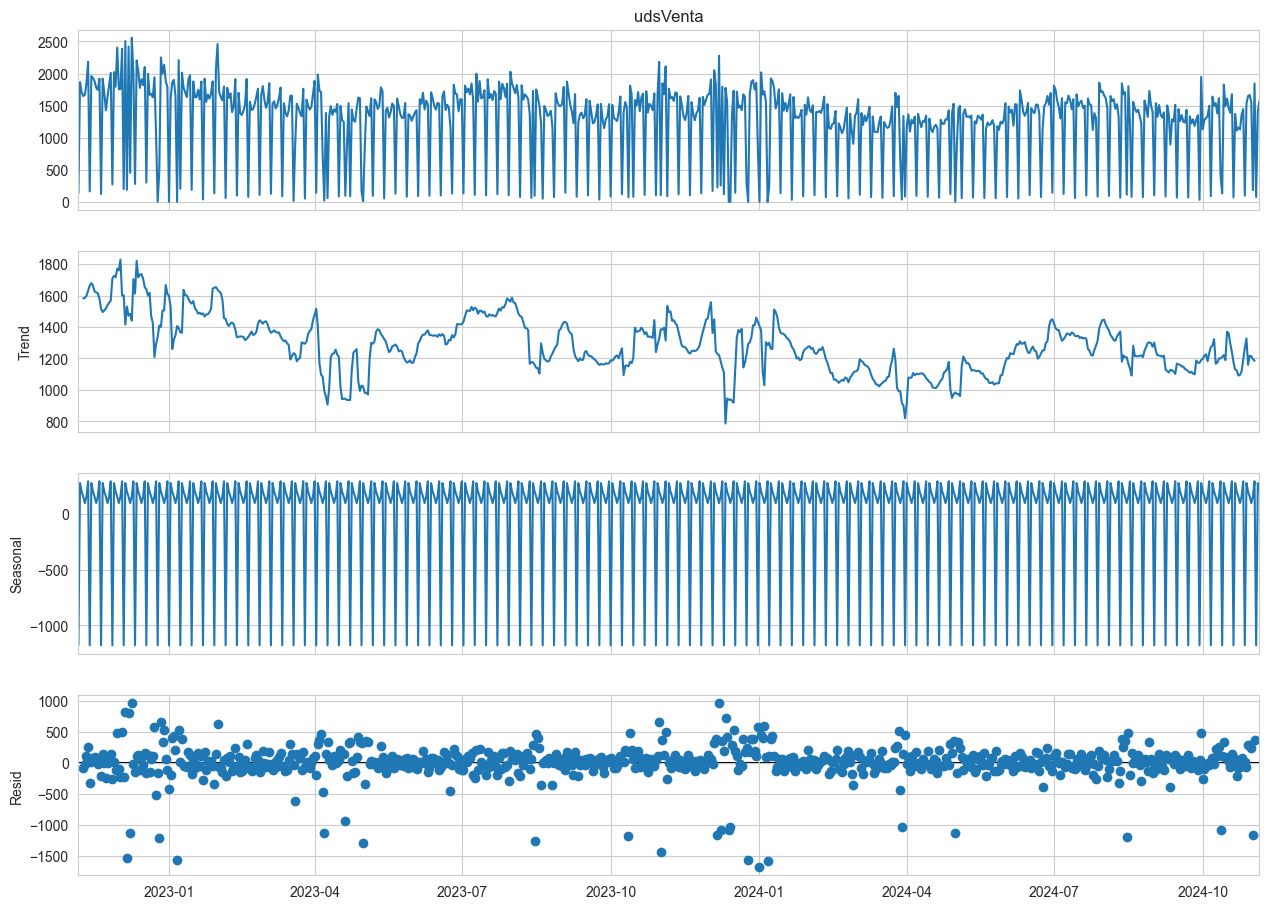

In [65]:
descomposicion = sm.tsa.seasonal_decompose(datos_ventas_stock_calendario.groupby(datos_ventas_stock_calendario['idSecuencia'])['udsVenta'].sum(), model='additive', period=7)
fig = descomposicion.plot()
fig.set_size_inches(14,10)
plt.show()

En estas gráficas se puede observar que hay un patrón repetitivo con caídas muy marcadas cada semana. Se observa qye tiene estacionalidad semanal muy fuerte, “dientes de sierra” característicos, y además una tendencia no constante, lo que hace imprescindible separar componentes.

En la gráfica de tendencia se puede observar que la demanda no es estable, si no que disminuye suavemente a lo largo del tiempo con ligeros repuntes cíclicos.

En cuanto a la estacionalidad, se observa un patrón semanal muy definido y perfectamente repetido. Por lo tanto, la demanda depende del día de la seamana. 

En cuando a los residuos, se observa que existen algunos picos al inicio de 2023 y a finales de 2023, así como algunos aislados en 2024. Esto indica la presencia de eventos no explicados por el calendario.

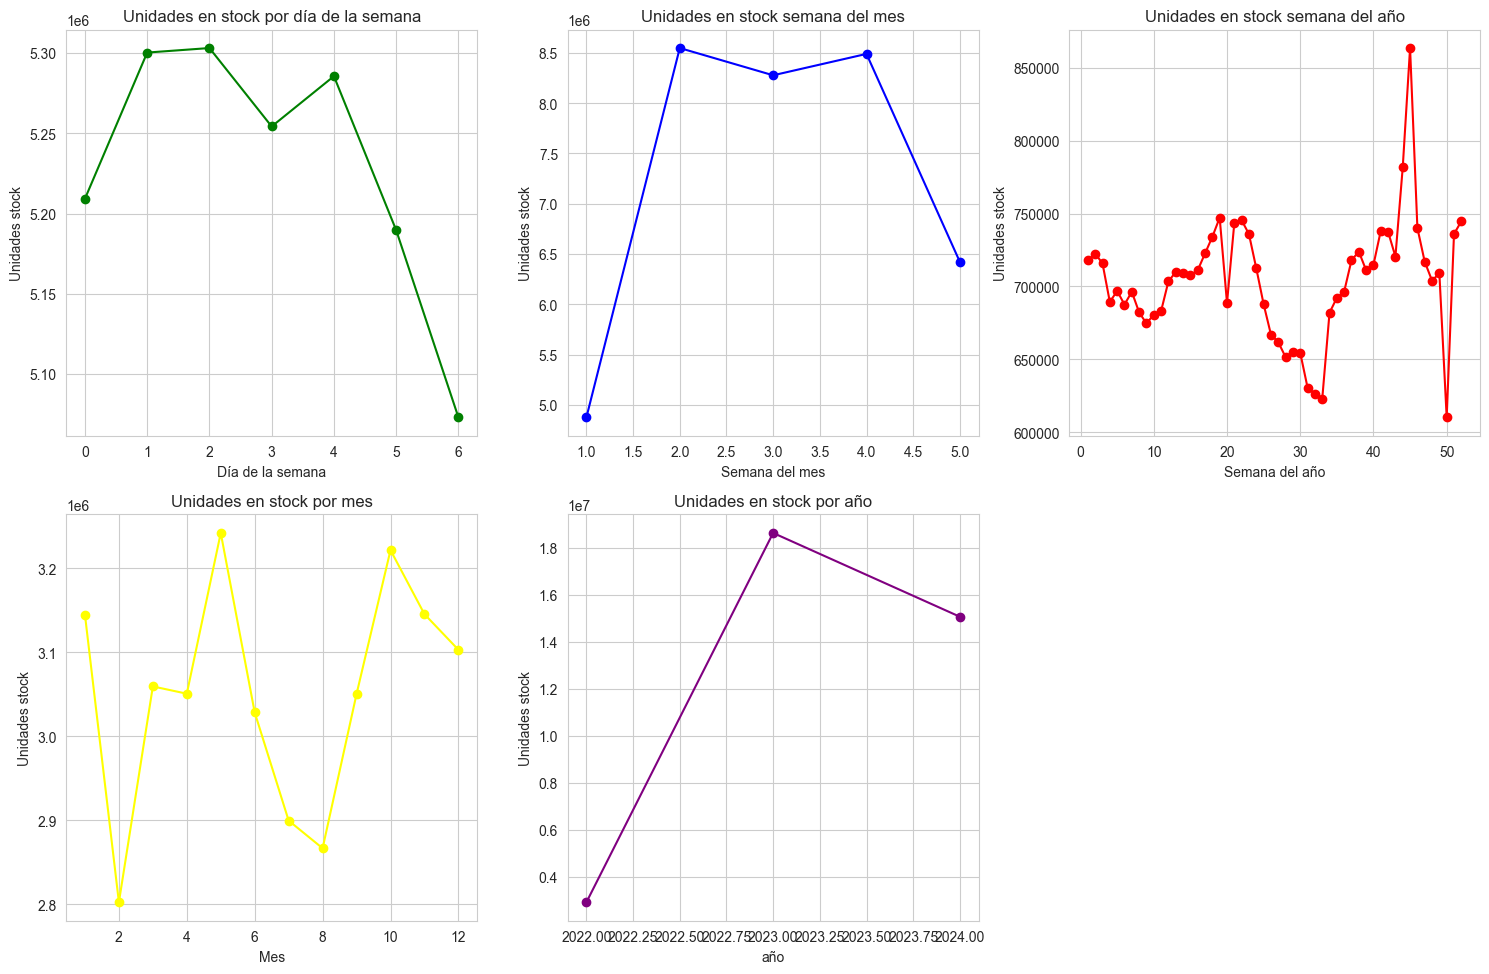

In [49]:
# Calculamos las uds en stock por día de la semana, semana del mes, semana del año, mes y año

stock_dia_semana = datos_ventas_stock_calendario.groupby(datos_ventas_stock_calendario['dia_semana'])['udsStock'].sum()
stock_senana_mes = datos_ventas_stock_calendario.groupby(datos_ventas_stock_calendario['semana_mes'])['udsStock'].sum()
stock_semana_año = datos_ventas_stock_calendario.groupby(datos_ventas_stock_calendario['semana'])['udsStock'].sum()
stock_mes = datos_ventas_stock_calendario.groupby(datos_ventas_stock_calendario['mes'])['udsStock'].sum()
stock_año = datos_ventas_stock_calendario.groupby(datos_ventas_stock_calendario['año'])['udsStock'].sum()

# Configurar las gráficas
sns.set_style('whitegrid')
plt.figure(figsize=(15,10))

# Gráfica ventas por día de la semana
plt.subplot(2,3,1)
plt.plot(stock_dia_semana.index, stock_dia_semana.values, marker='o', color='green')
plt.title('Unidades en stock por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Unidades stock')

# Gráfica de ventas por semana del mes
plt.subplot(2,3,2)
plt.plot(stock_senana_mes.index, stock_senana_mes.values, marker='o', color='blue')
plt.title('Unidades en stock semana del mes')
plt.xlabel('Semana del mes')
plt.ylabel('Unidades stock')

# Gráfica de ventas por semana del año
plt.subplot(2,3,3)
plt.plot(stock_semana_año.index, stock_semana_año.values, marker='o', color='red')
plt.title('Unidades en stock semana del año')
plt.xlabel('Semana del año')
plt.ylabel('Unidades stock')

# Gráfica de ventas por mes
plt.subplot(2,3,4)
plt.plot(stock_mes.index, stock_mes.values, marker='o', color='yellow')
plt.title('Unidades en stock por mes')
plt.xlabel('Mes')
plt.ylabel('Unidades stock')

# Gráfica de ventas por año
plt.subplot(2,3,5)
plt.plot(stock_año.index, stock_año.values, marker='o', color='purple')
plt.title('Unidades en stock por año')
plt.xlabel('año')
plt.ylabel('Unidades stock')

plt.tight_layout()
plt.show()

El análisis desglosado de los niveles de inventario muestra patrones claros a nivel semanal, mensual y anual. A corto plazo, el stock sigue un ciclo semanal en el que los niveles aumentan al inicio de la semana, coincidiendo con las reposiciones, y disminuyen progresivamente hasta alcanzar su mínimo el domingo. A nivel mensual, se observan picos en la segunda semana del mes, lo que sugiere actividades de abastecimiento vinculadas al calendario operativo.

A largo plazo, el stock presenta fluctuaciones anuales coherentes con las campañas comerciales y los picos de demanda, siendo especialmente alto en los meses previos a eventos clave como el verano o la campaña navideña. Finalmente, la evolución anual refleja tanto la disponibilidad de datos como posibles cambios en las políticas de inventario.

Vamos a analizar las dos variables juntas: stock y unidades vendidas. Para poder ver mejor los resultados, vamos a realizar un reescalado de los datos.

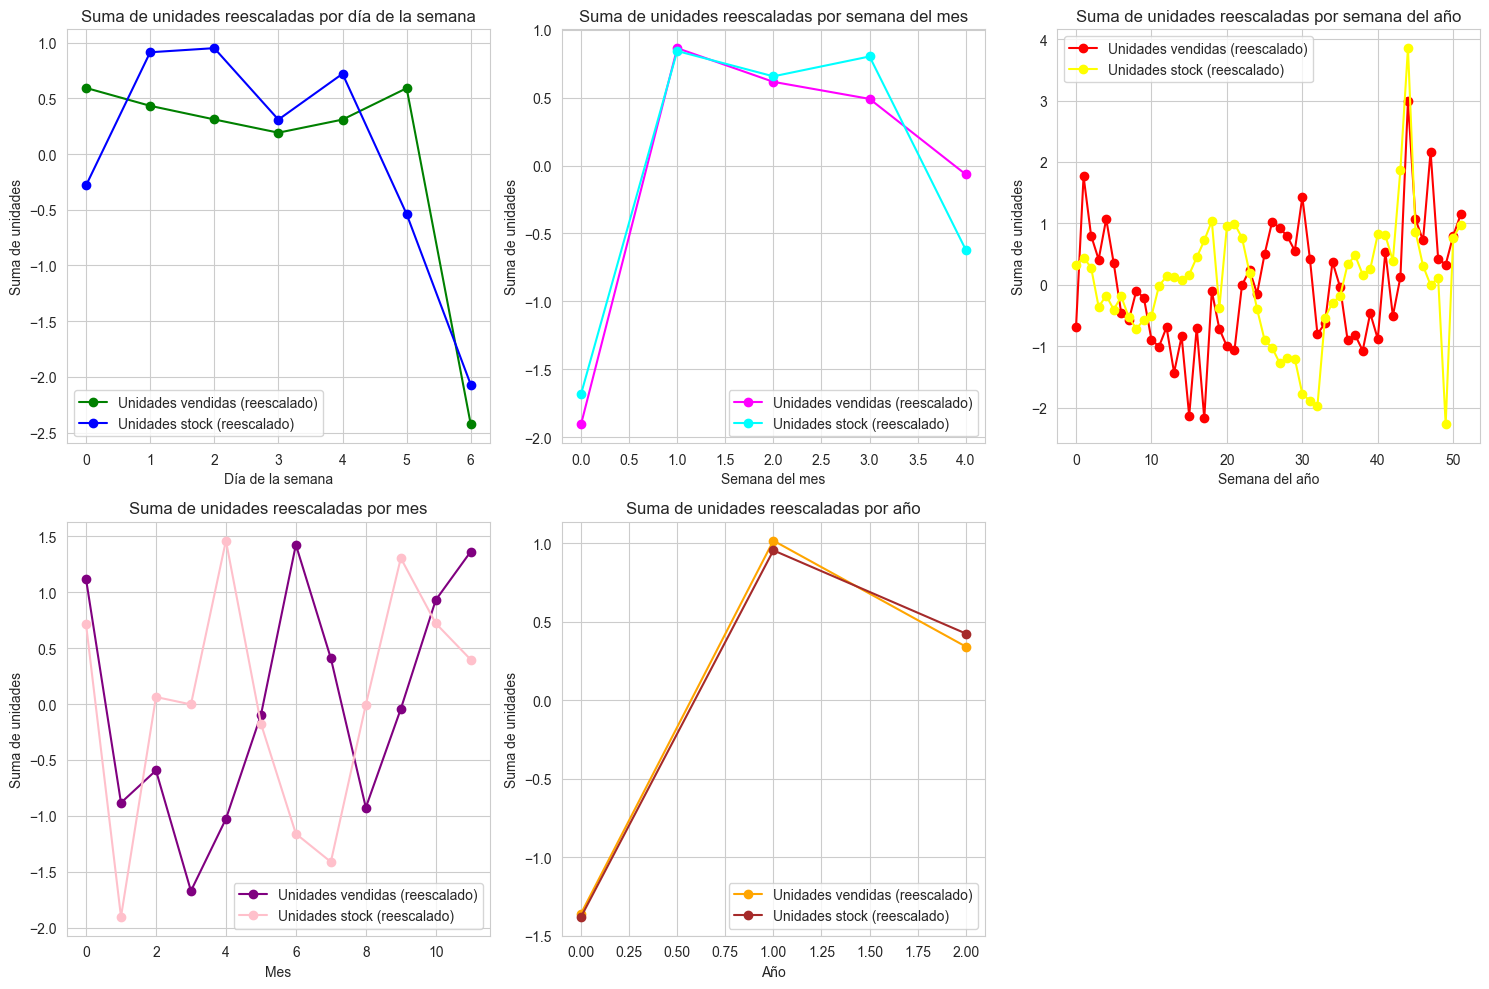

In [50]:
scaler = StandardScaler()

ventas_dia_semana_scaled = scaler.fit_transform(ventas_dia_semana.values.reshape(-1,1)).flatten()
stock_dia_semana_scaled = scaler.fit_transform(stock_dia_semana.values.reshape(-1,1)).flatten()

ventas_senana_mes_scaled = scaler.fit_transform(ventas_senana_mes.values.reshape(-1,1)).flatten()
stock_senana_mes_scaled = scaler.fit_transform(stock_senana_mes.values.reshape(-1,1)).flatten()

ventas_semana_año_scaled = scaler.fit_transform(ventas_semana_año.values.reshape(-1,1)).flatten()
stock_semana_año_scaled = scaler.fit_transform(stock_semana_año.values.reshape(-1,1)).flatten()

ventas_mes_scaled = scaler.fit_transform(ventas_mes.values.reshape(-1,1)).flatten()
stock_mes_scaled = scaler.fit_transform(stock_mes.values.reshape(-1,1)).flatten()

ventas_año_scaled = scaler.fit_transform(ventas_año.values.reshape(-1,1)).flatten()
stock_año_scaled = scaler.fit_transform(stock_año.values.reshape(-1,1)).flatten()

# Graficamos los datos
sns.set_style('whitegrid')
plt.figure(figsize=(15,10))

# Gráfica por día de la semana
plt.subplot(2,3,1)
plt.plot(ventas_dia_semana_scaled, marker='o', color='green', label='Unidades vendidas (reescalado)')
plt.plot(stock_dia_semana_scaled, marker='o', color='blue', label='Unidades stock (reescalado)')
plt.title('Suma de unidades reescaladas por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Suma de unidades')
plt.legend()

# Gráfica por semana del mes
plt.subplot(2,3,2)
plt.plot(ventas_senana_mes_scaled, marker='o', color='magenta', label='Unidades vendidas (reescalado)')
plt.plot(stock_senana_mes_scaled, marker='o', color='cyan', label='Unidades stock (reescalado)')
plt.title('Suma de unidades reescaladas por semana del mes')
plt.xlabel('Semana del mes')
plt.ylabel('Suma de unidades')
plt.legend()

# Gráfica por semana del año
plt.subplot(2,3,3)
plt.plot(ventas_semana_año_scaled, marker='o', color='red', label='Unidades vendidas (reescalado)')
plt.plot(stock_semana_año_scaled, marker='o', color='yellow', label='Unidades stock (reescalado)')
plt.title('Suma de unidades reescaladas por semana del año')
plt.xlabel('Semana del año')
plt.ylabel('Suma de unidades')
plt.legend()

# Gráfica por mes
plt.subplot(2,3,4)
plt.plot(ventas_mes_scaled, marker='o', color='purple', label='Unidades vendidas (reescalado)')
plt.plot(stock_mes_scaled, marker='o', color='pink', label='Unidades stock (reescalado)')
plt.title('Suma de unidades reescaladas por mes')
plt.xlabel('Mes')
plt.ylabel('Suma de unidades')
plt.legend()

# Gráfica por año
plt.subplot(2,3,5)
plt.plot(ventas_año_scaled, marker='o', color='orange', label='Unidades vendidas (reescalado)')
plt.plot(stock_año_scaled, marker='o', color='brown', label='Unidades stock (reescalado)')
plt.title('Suma de unidades reescaladas por año')
plt.xlabel('Año')
plt.ylabel('Suma de unidades')
plt.legend()

plt.tight_layout()
plt.show()

Tras reescalar las series de ventas y stock para hacerlas comparables, se observa que ambas comparten patrones temporales consistentes en todas las escalas analizadas —día de la semana, semana del mes, semana del año, mes y año—.

La mayor similitud aparece en las escalas semanal y anual, donde ventas y stock evolucionan prácticamente en paralelo, lo que indica una planificación de inventario adecuada al comportamiento de la demanda. A nivel mensual se detectan ligeras desviaciones, probablemente asociadas a calendarios promocionales, variaciones de rotación o ajustes logísticos.

En conjunto, estas gráficas muestran que el stock responde de forma coherente a las necesidades del negocio, ajustándose tanto a la estacionalidad semanal como a las fluctuaciones anuales de la demanda.

Vamos a ver cuantos casos tenemos en los que las ventas están a 0 por rotura de stock.

In [51]:
rotura_stock = datos_ventas_stock_calendario[(datos_ventas_stock_calendario['udsStock'] == 0) & (datos_ventas_stock_calendario['udsVenta'] == 0)]
rotura_stock

,producto,idSecuencia,udsVenta,udsStock,bolOpen,bolHoliday,isPromo,año,mes,dia,dia_semana,semana,semana_mes
913,21,2022-11-06,0,0,0,1,0,2022,11,6,6,44,1
941,50,2022-11-06,0,0,0,1,0,2022,11,6,6,44,1
1243,391,2022-11-06,0,0,0,1,0,2022,11,6,6,44,1
1469,649,2022-11-06,0,0,0,1,0,2022,11,6,6,44,1
1583,775,2022-11-06,0,0,0,1,0,2022,11,6,6,44,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
654262,845,2024-11-05,0,0,1,0,0,2024,11,5,1,45,2
654278,861,2024-11-05,0,0,1,0,0,2024,11,5,1,45,2
654300,886,2024-11-05,0,0,1,0,0,2024,11,5,1,45,2
654325,913,2024-11-05,0,0,1,0,0,2024,11,5,1,45,2


Observamos que tenemos 25576 casos de rotura de stock. Vamos a ver los resultados por producto.

In [52]:
rotura_stock_por_producto = rotura_stock.groupby('producto').size().reset_index(name='registros afectados')
rotura_stock_por_producto

,producto,registros afectados
0,1,2
1,2,1
2,3,1
3,4,2
4,5,3
...,...,...
889,996,8
890,997,3
891,998,6
892,999,3


En el preprocesamiento de datos veremos que podemos hacer con estos casos de rotura de stock.

Por último, analizamos la correlacción de las variables del dataset.

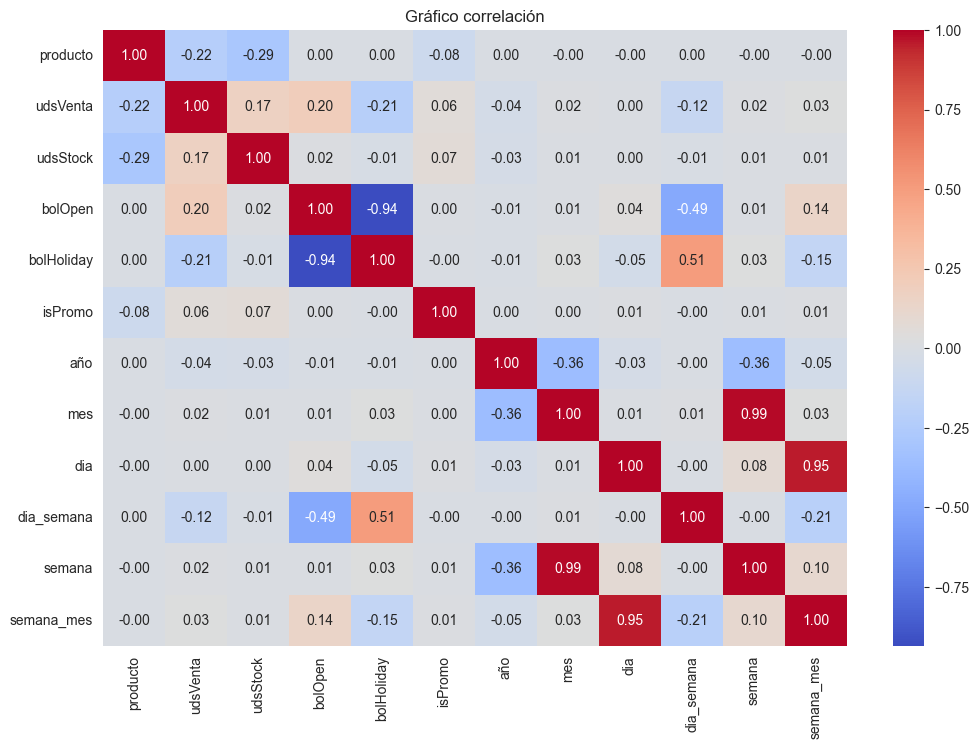

In [53]:
# Eliminamos las columnas no numéricas
data_numeric = datos_ventas_stock_calendario.drop(['idSecuencia'], axis=1)

# Calculamos la matriz de correlación
corr_matrix = data_numeric.corr()

# Graficamos la matriz
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Gráfico correlación')
plt.show()

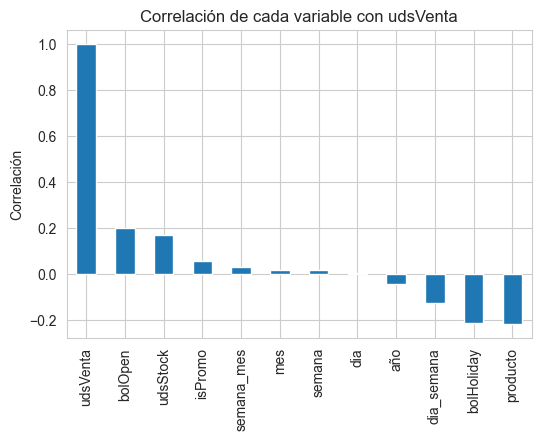

In [54]:
corr_target = corr_matrix['udsVenta'].sort_values(ascending=False)
plt.figure(figsize=(6,4))
corr_target.plot(kind='bar')
plt.title('Correlación de cada variable con udsVenta')
plt.ylabel('Correlación')
plt.show()

La matriz de correlación muestra que las relaciones lineales entre las variables explicativas y la demanda son relativamente débiles, lo que evidencia que la dinámica de ventas no sigue patrones lineales simples. Las correlaciones más fuertes se observan entre variables del calendario y entre indicadores operativos como bolOpen y bolHoliday, reflejando la estructura del negocio.

La baja correlación de udsVenta con variables como isPromo o dia_semana no implica falta de relación, sino que estas dependencias son no lineales, estacionales o contextuales, por lo que no son capturadas adecuadamente por Pearson.

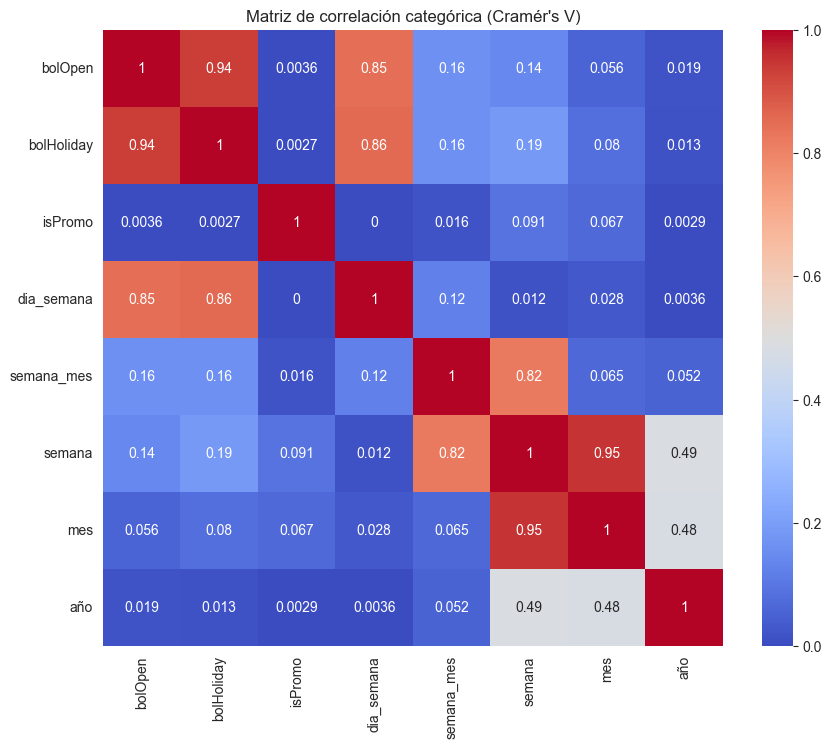

In [55]:
def cramers_v_corrected(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()

    # Corrected version
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)

    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cat_cols = ['bolOpen', 'bolHoliday', 'isPromo', 'dia_semana', 'semana_mes', 'semana', 'mes', 'año']

matriz_cramer = pd.DataFrame(index=cat_cols, columns=cat_cols)

for col1 in cat_cols:
    for col2 in cat_cols:
        matriz_cramer.loc[col1, col2] = cramers_v_corrected(
            datos_ventas_stock_calendario[col1],
            datos_ventas_stock_calendario[col2]
        )

matriz_cramer = matriz_cramer.astype(float)

plt.figure(figsize=(10, 8))
sns.heatmap(matriz_cramer, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Matriz de correlación categórica (Cramér's V)")
plt.show()



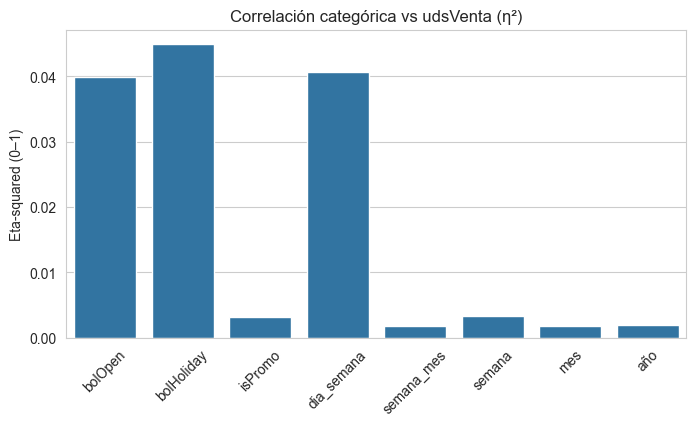

In [56]:
def eta_squared(df, categorical, numeric):
    categories = df[categorical].unique()
    
    # Media global
    y_mean = df[numeric].mean()
    
    # Suma de cuadrados entre grupos (SSB)
    ss_between = sum([
        len(df[df[categorical] == cat]) * (df[df[categorical] == cat][numeric].mean() - y_mean)**2
        for cat in categories
    ])
    
    # Suma total de cuadrados (SST)
    ss_total = sum((df[numeric] - y_mean)**2)
    
    return ss_between / ss_total

cat_cols = ['bolOpen', 'bolHoliday', 'isPromo', 'dia_semana', 'semana_mes', 'semana', 'mes', 'año']

eta_results = {}

for col in cat_cols:
    eta = eta_squared(datos_ventas_stock_calendario, col, 'udsVenta')
    eta_results[col] = eta

plt.figure(figsize=(8,4))
sns.barplot(x=list(eta_results.keys()), y=list(eta_results.values()))
plt.xticks(rotation=45)
plt.title("Correlación categórica vs udsVenta (η²)")
plt.ylabel("Eta-squared (0–1)")
plt.show()



El análisis de η² muestra que las variables categóricas que más explican la variación de las ventas son los festivos (bolHoliday), la apertura del establecimiento (bolOpen) y el día de la semana (dia_semana), todas ellas vinculadas a la estacionalidad operativa del negocio.

Por el contrario, variables como el mes, la semana del año o la semana del mes tienen un efecto muy pequeño, lo que sugiere que la estacionalidad mensual o anual no se manifiesta de forma lineal.

Finalmente, el efecto de la promoción (isPromo), aunque relevante en términos absolutos, muestra un η² reducido debido a la alta variabilidad dentro de los días promocionales y a su baja frecuencia relativa.

Estos resultados confirman que la demanda está dominada por patrones semanales y por el calendario operativo, mientras que la promoción actúa como un impulsor puntual, más que como un determinante estructural.

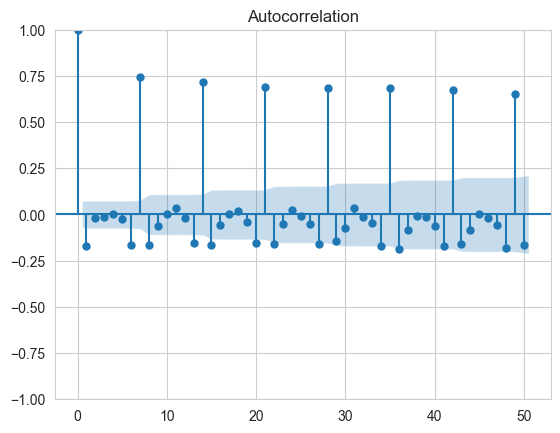

In [68]:
from statsmodels.graphics.tsaplots import plot_acf

s = datos_ventas_stock_calendario.groupby(datos_ventas_stock_calendario['idSecuencia'])['udsVenta'].sum()
plot_acf(s, lags=50)
plt.show()



El gráfico de autocorrelación (ACF) calculado sobre la serie agregada por día revela un patrón estacional muy claro de periodo semanal. Se observan picos significativos en los desfases 7, 14, 21, 28, 35 y 42, lo que indica que el comportamiento de la demanda en un día concreto es similar al que se produce ese mismo día de la semana en periodos posteriores.

# Export de datos

In [58]:
datos_ventas_stock_calendario.to_csv('Datos_Ventas_Stock_Calendario.csv', index=None, header=True)